# Inferring Product Lifecycles and Seasonality 

### What can we infer about the high-level Seasonality of an eCommerce retailer given a year of transaction-level data?
### What 

In [536]:
import pandas as pd
import numpy as np
import re
import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
##https://www.kaggle.com/vijayuv/onlineretail?select=OnlineRetail.csv

In [596]:
ttl = pd.read_csv('/Users/APinkerton/NYC_DS_A/projects/proj_1/OnlineRetail.csv',encoding= 'unicode_escape')
ttl.columns
ttl.head()
ttl.Country.value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [538]:
np.unique(ttl['InvoiceDate'])

array(['1/10/2011 10:04', '1/10/2011 10:07', '1/10/2011 10:08', ...,
       '9/9/2011 9:13', '9/9/2011 9:38', '9/9/2011 9:52'], dtype=object)

In [539]:
date = ttl.InvoiceDate.str.split(" ",expand=True)
full = pd.merge(ttl, date, left_index=True, right_index=True)
full.drop(columns=['InvoiceDate',1],inplace=True)
full.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,12/1/2010
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,12/1/2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,12/1/2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,12/1/2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,12/1/2010


In [540]:
full['Sales_(GBP)']=full['Quantity']*full['UnitPrice']
full['ret'] = full['Quantity'] < 0
full.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0,Sales_(GBP),ret
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,12/1/2010,15.30,False
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,12/1/2010,20.34,False
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,12/1/2010,22.00,False
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,12/1/2010,20.34,False
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,12/1/2010,20.34,False


In [541]:
full[0]=pd.to_datetime(full[0])
full['Month']=full[0].dt.month
full['day']=full[0].dt.day
full['year']=full[0].dt.year
full.columns
full.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0,Sales_(GBP),ret,Month,day,year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,15.30,False,12,1,2010
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,22.00,False,12,1,2010
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010


In [542]:
dates = pd.read_csv('/Users/APinkerton/NYC_DS_A/projects/proj_1/days.csv')
dates['date']=pd.to_datetime(dates['date'])
dates.rename(columns={'Unnamed: 2':'woy'},inplace=True)

In [543]:
new = pd.merge(full,dates,left_on=0,right_on='date')
new.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0,Sales_(GBP),ret,Month,day,year,date,Wk,woy
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,15.30,False,12,1,2010,2010-12-01,DEC Wk 1,48
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,22.00,False,12,1,2010,2010-12-01,DEC Wk 1,48
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48


In [544]:
new['454_Month'] = new['Wk'].astype(str).str[0:3]
new.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0,Sales_(GBP),ret,Month,day,year,date,Wk,woy,454_Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,15.30,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,22.00,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,12,1,2010,2010-12-01,DEC Wk 1,48,DEC


In [545]:
new.groupby(['StockCode','Description'])[['woy']].agg('min')

new.groupby(['StockCode','Description', 'Wk']).agg('sum').head()
week_ttl = new.groupby(['Wk'])[['Quantity','Sales_(GBP)']].agg('sum')

cal_month_ttl = new.groupby(['Month'])[['Quantity','Sales_(GBP)']].agg('sum').copy()
cal_month_ttl['Unit_Cost']=cal_month_ttl['Sales_(GBP)']/cal_month_ttl['Quantity']
ttlsls = cal_month_ttl['Sales_(GBP)'].sum()
ttlquan = cal_month_ttl['Quantity'].sum()
monthly_ttls = (ttlsls,ttlquan)
cal_month_ttl['% to Sls'] = cal_month_ttl['Sales_(GBP)'] / ttlsls
cal_month_ttl['% to Quan'] = cal_month_ttl['Quantity'] / ttlquan
cal_month_ttl['build']=round(cal_month_ttl['Sales_(GBP)']/cal_month_ttl['Sales_(GBP)'].shift(1,axis=0),2)
cal_month_ttl['build'][1]= round((cal_month_ttl['Sales_(GBP)'][1])/(cal_month_ttl['Sales_(GBP)'][12]),2)

month_454_ttl = new.groupby(['454_Month'])[['Quantity','Sales_(GBP)']].agg('sum')
yyz = cal_month_ttl.copy()
print(yyz.index)
yyz.reset_index()
yyz

Int64Index([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], dtype='int64', name='Month')


<ipython-input-545-48e7478eeda7>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cal_month_ttl['build'][1]= round((cal_month_ttl['Sales_(GBP)'][1])/(cal_month_ttl['Sales_(GBP)'][12]),2)


,Quantity,Sales_(GBP),Unit_Cost,% to Sls,% to Quan,build
Month,,,,,,
1,308966,560000.260,1.812498,0.057449,0.059687,0.47
2,277989,498062.650,1.791663,0.051095,0.053703,0.89
3,351872,683267.080,1.941806,0.070095,0.067976,1.37
4,289098,493207.121,1.706021,0.050597,0.055849,0.72
5,380391,723333.510,1.901553,0.074205,0.073485,1.47
6,341623,691123.120,2.023058,0.070901,0.065996,0.96
7,391116,681300.111,1.741939,0.069893,0.075557,0.99
8,406199,682680.510,1.680655,0.070035,0.078471,1.00
9,549817,1019687.622,1.854595,0.104608,0.106215,1.49


In [546]:
# yyz.drop(['Unit_Cost'],axis=1,inplace=True)

In [547]:
# new.groupby(['Income Group', 'Region'])[['GDP']].agg(np.mean).loc[['High income: OECD', 'High income: nonOECD']]

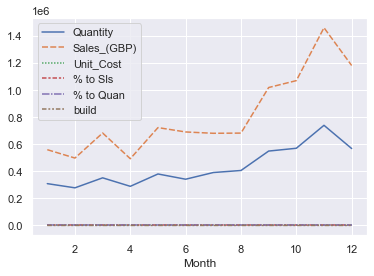

In [548]:
sns.set_theme(style="darkgrid")
sns.lineplot(data=yyz)#,style)
plt.show()

In [549]:
mask1 = new['ret']
returns = new.loc[mask1, :].copy()
returns['Unit_Cost']=returns['Sales_(GBP)']/returns['Quantity']

ttlretdol = returns['Sales_(GBP)'].sum()
ttlretquan = returns['Quantity'].sum()

returns['% to Ret$'] = returns['Sales_(GBP)'] / ttlretdol
returns['% to RetU'] = returns['Quantity'] / ttlretquan


ttl_mo_ret = returns.groupby(['Month'])[['Quantity','Sales_(GBP)','% to Ret$','% to RetU']].agg('sum')

ttl_mo_ret['% to RetU'] = ttl_mo_ret['Quantity'] / ttlretdol
monthly_ttls = (ttlretdol,ttlretquan)
ttl_mo_ret

,Quantity,Sales_(GBP),% to Ret$,% to RetU
Month,,,,
1,-88750,-131364.30,0.146479,0.098962
2,-8706,-25569.24,0.028511,0.009708
3,-33078,-34372.28,0.038327,0.036884
4,-23078,-44601.50,0.049733,0.025733
5,-19034,-47202.51,0.052634,0.021224
6,-52714,-70616.78,0.078742,0.058779
7,-16423,-37921.08,0.042284,0.018313
8,-18817,-54333.75,0.060585,0.020982
9,-25599,-38902.55,0.043379,0.028544


In [550]:
new.columns

Index([  'InvoiceNo',   'StockCode', 'Description',    'Quantity',
         'UnitPrice',  'CustomerID',     'Country',             0,
       'Sales_(GBP)',         'ret',       'Month',         'day',
              'year',        'date',          'Wk',         'woy',
         '454_Month'],
      dtype='object')

In [551]:
prod_tbl = new.groupby(['StockCode','Description'])[['Sales_(GBP)','Quantity']].agg('sum')
above10 = prod_tbl.sort_values(by='Sales_(GBP)',ascending=False).head(217)
topsls = above10['Sales_(GBP)'].sum()
topquan = above10['Quantity'].sum()
# print(topsls,topquan)
print(above10)

                                              Sales_(GBP)  Quantity
StockCode Description                                              
DOT       DOTCOM POSTAGE                        206245.48       707
22423     REGENCY CAKESTAND 3 TIER              164762.19     13033
47566     PARTY BUNTING                          98302.98     18022
85123A    WHITE HANGING HEART T-LIGHT HOLDER     97715.99     35025
85099B    JUMBO BAG RED RETROSPOT                92356.03     47363
...                                                   ...       ...
82600     NO SINGING METAL SIGN                  10122.56      4751
22169     FAMILY ALBUM WHITE PICTURE FRAME       10096.71      1166
23170     REGENCY TEA PLATE ROSES                10070.75      6151
23582     VINTAGE DOILY JUMBO BAG RED            10010.77      4694
22633     HAND WARMER UNION JACK                 10002.72      4841

[217 rows x 2 columns]


In [552]:
below10 = prod_tbl.sort_values(by='Sales_(GBP)',ascending=False).head(~217)
botsls = below10['Sales_(GBP)'].sum()
botquan = below10['Quantity'].sum()
print(topsls/botsls,topquan/botquan)

0.4722343549120401 0.33655731768860775


In [572]:
mds = new[['StockCode','UnitPrice']]
mds = mds.apply(tuple,axis=1)
md = pd.DataFrame(set(mds))
md.sort_values(by=[0,1],axis=1,inplace=True, ascending=False)
# md.to_csv('md.csv')
price_tbl = pd.read_csv('/Users/APinkerton/NYC_DS_A/projects/proj_1/mds.csv')
price_tbl.head()

,StockCode,Unit_Price,Price_Flag,Num_of_Pr,Ever_Marked
0,10002,1.66,Reg_Price,4,Marked
1,10002,1.63,MD,4,Marked
2,10002,0.85,MD,4,Marked
3,10002,0.00,MD,4,Marked
4,10080,0.85,Reg_Price,3,Marked


In [590]:
price_perf = new.copy()
price_perf.head()
pricing_sales = price_perf.merge(price_tbl, how='left', left_on=['StockCode','UnitPrice'], right_on=['StockCode','Unit_Price'])
pricing_sales.head()
mask1 = pricing_sales['Ever_Marked']=='Marked'
mask2 = pricing_sales['ret']==False
# pricing_sales.loc[mask1 & mask2,:]
reg_md = pricing_sales.loc[mask1 & mask2, :].copy()
reg_md.head()

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,0,Sales_(GBP),ret,...,day,year,date,Wk,woy,454_Month,Unit_Price,Price_Flag,Num_of_Pr,Ever_Marked
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850.0,United Kingdom,2010-12-01,15.30,False,...,1,2010,2010-12-01,DEC Wk 1,48,DEC,2.55,MD,10,Marked
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,...,1,2010,2010-12-01,DEC Wk 1,48,DEC,3.39,MD,4,Marked
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850.0,United Kingdom,2010-12-01,22.00,False,...,1,2010,2010-12-01,DEC Wk 1,48,DEC,2.75,MD,11,Marked
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,...,1,2010,2010-12-01,DEC Wk 1,48,DEC,3.39,MD,8,Marked
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850.0,United Kingdom,2010-12-01,20.34,False,...,1,2010,2010-12-01,DEC Wk 1,48,DEC,3.39,MD,12,Marked


In [595]:
final_pricing = reg_md.groupby(['Price_Flag', 'Wk','woy'])['Sales_(GBP)','Quantity'].agg(['sum','count']).copy()
final_pricing.head()

<ipython-input-595-e71c7399a2e9>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  final_pricing = reg_md.groupby(['Price_Flag', 'Wk','woy'])['Sales_(GBP)','Quantity'].agg(['sum','count']).copy()


Sales_(GBP)       Quantity      
                                sum count      sum count
Price_Flag Wk       woy                                 
MD         APR Wk 1 14    128162.86  7111    65914  7111
           APR Wk 2 15    142879.82  6960    80925  6960
           APR Wk 3 16    149942.92  8401    87898  8401
           APR Wk 4 17     76999.26  4068    46884  4068
           APR Wk 5 13     24898.03  1179    17874  1179

In [554]:
by_prod = new.groupby(['StockCode','Description','Month'])[['Quantity','Sales_(GBP)']].agg(['sum']).copy()

In [555]:
top = new.groupby(['StockCode','Description'])[['Quantity','Sales_(GBP)']].agg(['sum']).copy()
top.columns
top_prod = top.sort_values(('Sales_(GBP)', 'sum'),ascending=False).head(25).copy()
top25=[]
for [s,d] in top_prod.index:
    top25.append(d)
top25

['DOTCOM POSTAGE',
 'REGENCY CAKESTAND 3 TIER',
 'PARTY BUNTING',
 'WHITE HANGING HEART T-LIGHT HOLDER',
 'JUMBO BAG RED RETROSPOT',
 'RABBIT NIGHT LIGHT',
 'POSTAGE',
 "PAPER CHAIN KIT 50'S CHRISTMAS ",
 'ASSORTED COLOUR BIRD ORNAMENT',
 'CHILLI LIGHTS',
 'SPOTTY BUNTING',
 'JUMBO BAG PINK POLKADOT',
 'BLACK RECORD COVER FRAME',
 'PICNIC BASKET WICKER 60 PIECES',
 'SET OF 3 CAKE TINS PANTRY DESIGN ',
 'DOORMAT KEEP CALM AND COME IN',
 'JAM MAKING SET WITH JARS',
 'WOOD BLACK BOARD ANT WHITE FINISH',
 'LUNCH BAG RED RETROSPOT',
 'POPCORN HOLDER',
 'HOT WATER BOTTLE TEA AND SYMPATHY',
 'VICTORIAN GLASS HANGING T-LIGHT',
 'CHOCOLATE HOT WATER BOTTLE',
 'JUMBO BAG STRAWBERRY',
 'PAPER CHAIN KIT VINTAGE CHRISTMAS']